In [1]:
import os
import math
import pandas as pd
import numpy as np
from pathlib import Path
import shutil
import argparse
from typing import List, Union
import matplotlib.pyplot as plt
import yaml
from datetime import datetime
import logging
import math

import torch
from torch import Tensor, nn
from torch.types import Device, _size
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import init
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from collections import OrderedDict

# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
from configs.config import configs

from models.resnet1D import *
from models.transformer_encoder import transformer_classifier


2024-09-08 15:46:06.156141: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-08 15:46:06.175386: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-08 15:46:06.456794: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Initilization

In [ ]:
# Init logging
import logging

logger = logging.getLogger(__name__)  # Use the current module's name
logging.basicConfig(level=logging.DEBUG)
# logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler()
# formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
# handler.setFormatter(formatter)
logger.addHandler(handler)
acc_example = 0.95  # Replace with your actual accuracy calculation
logger.info(f"Current accuracy: %{acc_example}")  # Log as info
# logger.debug("Current accuracy: %.2f", accuracy)  # Log as info

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument("config_file", metavar="FILE", help="config file")
# parser.add_argument('--run-dir', metavar='DIR', help='run directory')
# parser.add_argument('--pdb', action='store_true', help='pdb')
args = parser.parse_args(args=['configs/abnormal_12000.yml'])
# args, opts = parser.parse_known_args()
# f = 'configs/eeg_pt.yml'
with open(args.config_file, 'r') as file:
    Configs = yaml.safe_load(file)

### Dataset

In [2]:
class customDataset(Dataset):
    def __init__(self, data_dir:str, label_dir:str, label_dict:dict, transform=None):
#         self.annotations = pd.read_csv(label_dir)
        self.data_dir = data_dir   # './data/origin_csv/train'
        self.label_dir = label_dir
        self.transform = transform
        self.files = os.listdir(self.data_dir)
        self.annotations = pd.read_csv(self.label_dir)
        self.label_dict = label_dict
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        data_path = os.path.join(self.data_dir, self.files[index])
        data = pd.read_csv(data_path)
        data = torch.tensor(data.values, dtype=torch.float32)
        file_name = self.files[index]
        
        label = torch.tensor(int(self.label_dict[self.annotations.iloc[index,1]]))
        
        if self.transform:
            data = self.transform(data)
            
#         return (data.t(), label, file_name)
#         return (data.t(), label, file_name)
        return (data, label, file_name)

In [25]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Args:
            x: `embeddings`, shape (batch, max_len, d_model)

        Returns:
            `encoder input`, shape (batch, max_len, d_model)
        """
        x = x + self.pe[: x.size(1)]
        return self.dropout(x)

In [4]:
train_dataset = customDataset(data_dir='../data/seg_csv/train_12000',
                                  label_dir='../data/edf_label_12000.csv',
                                  label_dict={'normal':0, 'abnormal':1})

In [5]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16,
                              shuffle=True, pin_memory=True)

In [66]:
x = torch.tensor(df.values)

In [67]:
x.shape

torch.Size([12000, 19])

In [68]:
batch = 16
d_model = 19
max_len = 12000
pe = PositionalEncoding(d_model=d_model, max_len=max_len)

In [28]:
data = iter(train_loader)

In [29]:
batch_data = next(data)

In [ ]:
batch_data[0].shape

In [99]:
out = pe(x)

In [101]:
out.shape

torch.Size([1, 12000, 19])

In [102]:
out_1 = out[0].T

In [94]:
out_1[0].shape

torch.Size([12000])

In [16]:
div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

In [20]:
torch.arange(0, d_model, 2)

tensor([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18])

In [47]:
df = Tensor.numpy(out)

In [82]:
df[:,0]

InvalidIndexError: (slice(None, None, None), 0)

In [49]:
df_0 = df[0].T

In [77]:
df_0[0].shape

(12000,)

In [60]:
batch_data[0][0].T.shape

torch.Size([19, 12000])

In [64]:
df.shape

(12000, 19)

In [62]:
df = pd.read_csv('../data/seg_csv/train_12000/aaaaacby_s004_t000_1.csv')

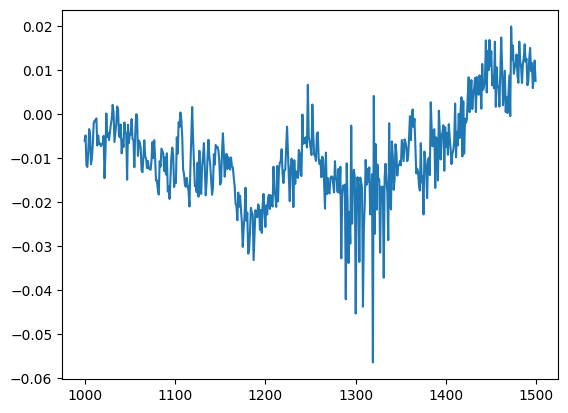

In [105]:
# Create a figure and a set of subplots
fig, ax = plt.subplots()  # Adjust the grid size as needed
ax = ax.plot(df.iloc[1000:1500,10])
# ax.set_title(f'Channel {df.iloc[0,1]}')
# ax.set_xlabel('Sample Index')
# ax.set_ylabel('Signal Value')
plt.show()

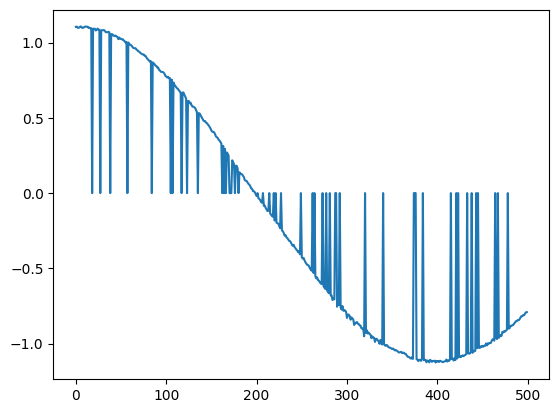

In [104]:
fig, ax = plt.subplots()  # Adjust the grid size as needed
ax = ax.plot(out_1[10,1000:1500])
# ax.set_title(f'Channel {df.iloc[0,1]}')
# ax.set_xlabel('Sample Index')
# ax.set_ylabel('Signal Value')
plt.show()